# Facial Emotion Recognition using AffectNet dataset with PyTorch

### Notebook 02

This notebook is to carry out the building of models for Facial Emotion recognition (FER) using the `AffectNet` dataset. Experiments to build the best model would be done here.


In [100]:
# Import libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset, ConcatDataset
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.optim as optim
import torchinfo
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torchinfo import summary
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from pathlib import Path
import os
import sys
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import random
import numpy as np
import pandas as pd
from collections import Counter





In [2]:
# Get the absolute path to the project root (one level up from the notebook's directory)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the project root to the Python path
sys.path.append(project_root)

In [3]:
# Import the custom modules
from scripts.data_etl import CustomDataset, DataETL
from utils.common import get_mean_std

<u>Work Plan</u>

1. Load the dataset using ETL
2. Build a baseline model and evaluate
3. Convert training and evaluation loop into a function
4. Experiment with different models - custom and transfer learning
5. Deploy the best model as a flask app for webcam enabled  real time recognition of emotions.

### 1. Load the dataset

In [4]:
proj_dir = Path('/Users/sho_mac/Library/CloudStorage/OneDrive-Personal/Documents/Personal Project Portfolio/Facial-Emotion-Recognition-using-AffectNet-Dataset-with-PyTorch')

In [5]:
# create path variable for data directory
data_dir = Path(proj_dir / 'data_new')
data_dir

PosixPath('/Users/sho_mac/Library/CloudStorage/OneDrive-Personal/Documents/Personal Project Portfolio/Facial-Emotion-Recognition-using-AffectNet-Dataset-with-PyTorch/data_new')

In [101]:
# Create path for models directory
model_dir = Path(proj_dir / 'models')

In [6]:
data_etl = DataETL(data_dir, 42, number_of_images=None, balanced_data=None)

In [7]:
dataset = CustomDataset(data_dir, transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))

loader = DataLoader(dataset, batch_size=32, shuffle=True)

[2025-10-25 10:02:34,659: INFO: data_etl: Initializing custom data extraction...]
[2025-10-25 10:02:34,786: INFO: data_etl: Custom data extraction done.]


In [8]:
image, label = next(iter(loader))

In [9]:
image[2].shape

torch.Size([3, 224, 224])

In [10]:
# Load the dataset
data_etl = DataETL(data_dir, 42, 20000, False)

In [11]:
dataset = data_etl.extract_data(transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]))

[2025-10-25 10:02:37,886: INFO: data_etl: Extracting data......]
[2025-10-25 10:02:37,888: INFO: data_etl: Initializing custom data extraction...]
[2025-10-25 10:02:37,950: INFO: data_etl: Custom data extraction done.]
[2025-10-25 10:02:37,951: INFO: data_etl: Data extraction done......]


In [31]:

train_data, val_data, test_data = data_etl.transform_load(aug_class=['sad', 'disgust', 'contempt', 'fear', 'anger', 'neutral', 'happy'])


[2025-10-25 11:36:49,498: INFO: data_etl: Transformation started......]
[2025-10-25 11:36:49,500: INFO: data_etl: Initializing custom data extraction...]
[2025-10-25 11:36:49,645: INFO: data_etl: Custom data extraction done.]
[2025-10-25 11:36:49,646: INFO: common: Mean & std calculations......]


[2025-10-25 11:38:00,463: INFO: data_etl: Extracting data......]
[2025-10-25 11:38:00,464: INFO: data_etl: Initializing custom data extraction...]
[2025-10-25 11:38:00,528: INFO: data_etl: Custom data extraction done.]
[2025-10-25 11:38:00,529: INFO: data_etl: Data extraction done......]
[2025-10-25 11:38:00,529: INFO: data_etl: Splitting data started.......]
[2025-10-25 11:38:00,546: INFO: data_etl: Splitting data completed.......]
[2025-10-25 11:38:00,547: INFO: data_etl: Applying data augmentation to training data......]


Augmenting classes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:31<00:00,  4.48s/it]


[2025-10-25 11:41:39,588: INFO: data_etl: Train data count: 20136]
[2025-10-25 11:41:39,613: INFO: data_etl: Validation data count: 2000]
[2025-10-25 11:41:39,614: INFO: data_etl: Test data count: 2000]
[2025-10-25 11:41:39,615: INFO: data_etl: Transformation completed]


In [32]:
type(train_data)

torch.utils.data.dataset.TensorDataset

In [33]:
batch_size = 32

In [58]:
# Create the dataloaders
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0)
val_dataloader = DataLoader(val_data, shuffle=False, batch_size=batch_size, num_workers=0)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size, num_workers=0)

In [59]:
sample_images, sample_labels = next(iter(train_dataloader))

In [60]:
# Check the shape of a sample random image
sample_images[0].shape

torch.Size([3, 224, 224])

# Check class balance

In [61]:
sample_features, sample_label = train_data[0]

In [62]:
sample_label

tensor(2)

In [63]:
idx_to_class = {0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}


In [64]:
idx_to_class

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

In [65]:
class_counts = Counter([idx_to_class[label.item()] for batch in tqdm(train_dataloader) for label in batch[1]])
print("Class distribution:", class_counts)



  0%|          | 0/630 [00:00<?, ?it/s]

Class distribution: Counter({'surprise': 2517, 'sad': 2517, 'disgust': 2517, 'neutral': 2517, 'contempt': 2517, 'fear': 2517, 'anger': 2517, 'happy': 2517})


In [66]:
class_counts


Counter({'surprise': 2517,
         'sad': 2517,
         'disgust': 2517,
         'neutral': 2517,
         'contempt': 2517,
         'fear': 2517,
         'anger': 2517,
         'happy': 2517})

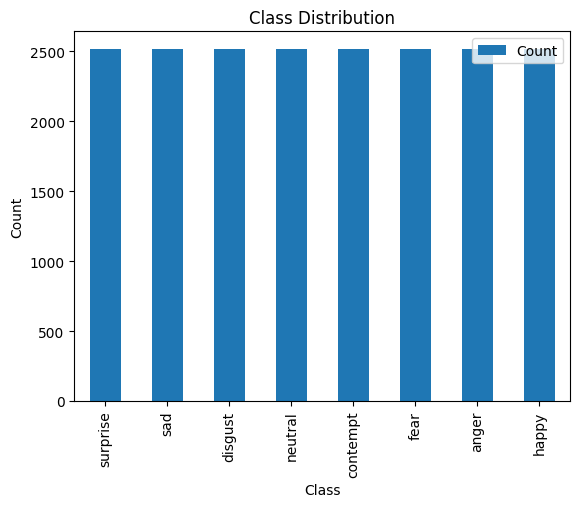

In [67]:
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [68]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using mps device.


In [69]:
model = torch.nn.Sequential()

In [70]:
# Convolutional layer 1 (sees 3x224x224 image tensor)
conv1 = nn.Conv2d(in_channels=3,
                 out_channels=16,
                 kernel_size=3,
                 padding=1)
model.append(conv1)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [71]:
max_pool1 = nn.MaxPool2d(2)
model.append(torch.nn.ReLU())
model.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [72]:
# Convolutional layer 2 (sees 16x112x112 tensor)
conv2 = nn.Conv2d(in_channels=16,
                 out_channels=32,
                 kernel_size=3,
                 padding=1)
max_pool2 = nn.MaxPool2d(2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [73]:
# Convolutional layer 3 (sees 32x56x56 tensor)
conv3 = nn.Conv2d(in_channels=32,
                 out_channels=64,
                 kernel_size=3,
                 padding=1)
max_pool3 = nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [74]:
model.append(torch.nn.Flatten())
model.append(nn.Dropout(0.5))

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
)

In [75]:
# Linear layer (64 * 28 * 28 -> 500)
linear1 = nn.Linear(in_features=50176,out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
)


In [76]:
# Linear layer (500 -> 5)
output_layer = nn.Linear(in_features=500,
                        out_features=8)
model.append(output_layer)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)


In [77]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [90]:
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

In [79]:
height = 224
width = 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

In [97]:
# **AI Lab: Deep Learning for Computer Vision**
# **WorldQuant University**
#
#

# **Usage Guidelines**
#
# This file is licensed under Creative Commons Attribution-NonCommercial-
# NoDerivatives 4.0 International.
#
# You **can** :
#
#   * ✓ Download this file
#   * ✓ Post this file in public repositories
#
# You **must always** :
#
#   * ✓ Give credit to WorldQuant University for the creation of this file
#   * ✓ Provide a link to the license
#
# You **cannot** :
#
#   * ✗ Create derivatives or adaptations of this file
#   * ✗ Use this file for commercial purposes
#
# Failure to follow these guidelines is a violation of your terms of service and
# could lead to your expulsion from WorldQuant University and the revocation
# your certificate.
#
#

from collections import Counter

import pandas as pd
import torch
from tqdm.notebook import tqdm


def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset, "counting classes"))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})


def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    training_loss = 0.0
    model.train()
    model.to(device)
    # Iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)


def predict(model, data_loader, device="cpu"):
    all_probs = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs


def score(model, data_loader, loss_fn, device="cpu"):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    n_observations = data_loader.batch_size * len(data_loader)
    average_loss = total_loss / n_observations
    accuracy = total_correct / n_observations
    return average_loss, accuracy


def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device='cpu',
    use_train_accuracy=True,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        # Train one epoch
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device=device)

        # Evaluate training results
        if use_train_accuracy:
            train_loss, train_accuracy = score(model, train_loader, loss_fn, device=device)
        else:
            train_loss = training_loss
            train_accuracy = 0
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device=device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"    Training loss: {train_loss:.2f}")
        if use_train_accuracy:
            print(f"    Training accuracy: {train_accuracy:.2f}")
        print(f"    Validation loss: {validation_loss:.2f}")
        print(f"    Validation accuracy: {validation_accuracy:.2f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


# This file © 2024 by WorldQuant University is licensed under CC BY-NC-ND 4.0.


In [98]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    model,
    optimizer,
    loss_fn,
    train_dataloader,
    val_dataloader,
    epochs=20,
    device=device,
    use_train_accuracy=True,
)

Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.07
    Training accuracy: 0.62
    Validation loss: 1.30
    Validation accuracy: 0.51


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.86
    Training accuracy: 0.72
    Validation loss: 1.26
    Validation accuracy: 0.53


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.71
    Training accuracy: 0.80
    Validation loss: 1.22
    Validation accuracy: 0.54


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.55
    Training accuracy: 0.87
    Validation loss: 1.22
    Validation accuracy: 0.55


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.37
    Training accuracy: 0.92
    Validation loss: 1.28
    Validation accuracy: 0.54


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.31
    Training accuracy: 0.95
    Validation loss: 1.26
    Validation accuracy: 0.54


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.22
    Training accuracy: 0.97
    Validation loss: 1.32
    Validation accuracy: 0.56


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.16
    Training accuracy: 0.98
    Validation loss: 1.37
    Validation accuracy: 0.55


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.13
    Training accuracy: 0.98
    Validation loss: 1.41
    Validation accuracy: 0.55


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.08
    Training accuracy: 0.99
    Validation loss: 1.44
    Validation accuracy: 0.56


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 11
    Training loss: 0.07
    Training accuracy: 0.99
    Validation loss: 1.53
    Validation accuracy: 0.56


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 12
    Training loss: 0.06
    Training accuracy: 1.00
    Validation loss: 1.57
    Validation accuracy: 0.54


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 13
    Training loss: 0.05
    Training accuracy: 1.00
    Validation loss: 1.56
    Validation accuracy: 0.55


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 14
    Training loss: 0.05
    Training accuracy: 1.00
    Validation loss: 1.54
    Validation accuracy: 0.55


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 15
    Training loss: 0.04
    Training accuracy: 1.00
    Validation loss: 1.54
    Validation accuracy: 0.55


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 16
    Training loss: 0.04
    Training accuracy: 1.00
    Validation loss: 1.52
    Validation accuracy: 0.56


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 17
    Training loss: 0.04
    Training accuracy: 1.00
    Validation loss: 1.52
    Validation accuracy: 0.56


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 18
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 1.68
    Validation accuracy: 0.56


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 19
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 1.72
    Validation accuracy: 0.55


Training:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/630 [00:00<?, ?it/s]

Scoring:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 20
    Training loss: 0.02
    Training accuracy: 1.00
    Validation loss: 1.60
    Validation accuracy: 0.56


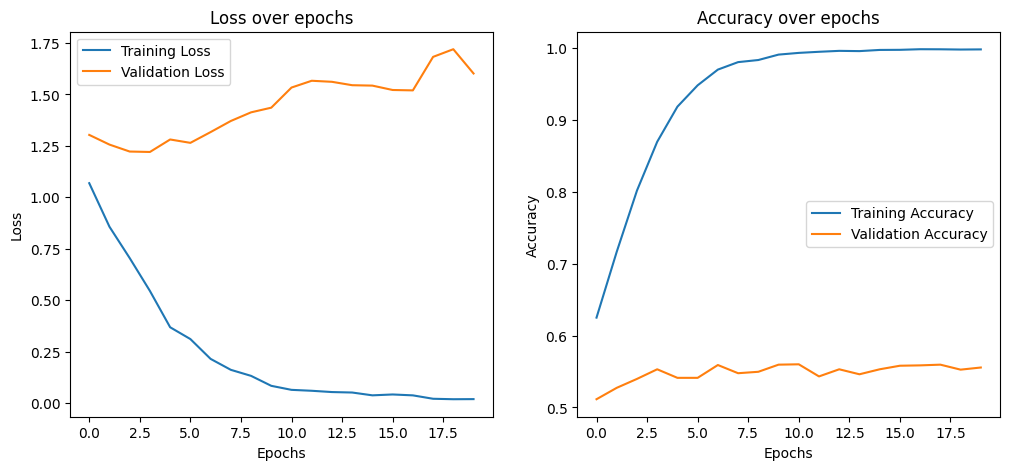

In [99]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
import os
from PIL import Image
import shutil
import random

def create_yolo_dataset(input_dir, output_dir, train_split=0.8):
    # Define emotion classes based on your dataset
    emotion_classes = ['fear', 'neutral', 'surprise', 'anger', 'contempt', 'disgust', 'sad', 'happy']
    class_to_id = {name: idx for idx, name in enumerate(emotion_classes)}
    
    # Create directories
    os.makedirs(os.path.join(output_dir, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'train', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', 'labels'), exist_ok=True)
    
    # Process each emotion folder
    for emotion in emotion_classes:
        emotion_dir = os.path.join(input_dir, emotion)
        if not os.path.exists(emotion_dir):
            continue
        images = [f for f in os.listdir(emotion_dir) if f.endswith(('.jpg', '.png'))]
        random.shuffle(images)  # Shuffle for random train/val split
        
        # Split into train and val
        train_size = int(len(images) * train_split)
        train_images = images[:train_size]
        val_images = images[train_size:]
        
        for split, split_images in [('train', train_images), ('val', val_images)]:
            for img_name in split_images:
                # Copy image
                img_path = os.path.join(emotion_dir, img_name)
                shutil.copy(img_path, os.path.join(output_dir, split, 'images', img_name))
                
                # Create label file (approximate bounding box: 80% of image)
                img = Image.open(img_path)
                width, height = img.size
                x_center = 0.5  # Normalized center
                y_center = 0.5
                box_width = 0.8  # 80% of image width
                box_height = 0.8
                class_id = class_to_id[emotion]
                
                # YOLO format: <class_id> <x_center> <y_center> <width> <height>
                label = f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n"
                label_path = os.path.join(output_dir, split, 'labels', f"{os.path.splitext(img_name)[0]}.txt")
                with open(label_path, 'w') as f:
                    f.write(label)

# Run the script
input_dir = 'path/to/affectnet'  # Update to your dataset path
output_dir = 'dataset'  # Output YOLO dataset
create_yolo_dataset(input_dir, output_dir)

In [ ]:
train: ./dataset/train/images
val: ./dataset/val/images
nc: 8
names: ['fear', 'neutral', 'surprise', 'anger', 'contempt', 'disgust', 'sad', 'happy']

In [ ]:
from ultralytics import YOLO
import torch

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
model = YOLO('yolov8n.pt')  # Nano model for efficiency
model.to(device)

# Train
model.train(
    data='dataset/data.yaml',
    epochs=20,
    imgsz=224,  # Smaller size for face-centric images
    batch=16,  # Adjust for MPS memory
    device=device,
    optimizer='Adam',
    lr0=0.001,
    patience=10,  # Early stopping
    name='emotion_yolov8'
)

In [ ]:
from ultralytics import YOLO
from PIL import Image
import cv2
import torch

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Load trained model
model = YOLO('runs/detect/emotion_yolov8/weights/best.pt')  # Path to trained model
model.to(device)

# Emotion classes
emotion_classes = ['fear', 'neutral', 'surprise', 'anger', 'contempt', 'disgust', 'sad', 'happy']

# Inference on a single image
image_path = 'path/to/test/image.jpg'
image = Image.open(image_path)
results = model(image, device=device)

# Visualize results
img = cv2.imread(image_path)
for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        conf = box.conf.item()
        cls = int(box.cls.item())
        emotion = emotion_classes[cls]
        # Draw bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Add label
        label = f"{emotion} ({conf:.2f})"
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Save and display
cv2.imwrite('output.jpg', img)
cv2.imshow('Result', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Evaluate
results = model.val(data='dataset/data.yaml', device=device)
print(results)  # Prints mAP, precision, recall, etc.

In [ ]:
augment: true

**Experiment with ResNet-50**

In [102]:
# Load pre-trained ResNet-50
model = models.resnet50(weights='IMAGENET1K_V1')
# Modify the final layer for 8 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)  # 8 emotion classes
model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/sho_mac/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:05<00:00, 18.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [103]:
# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [104]:

# Training function
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(1, epochs + 1):
        # Train
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validate
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch} Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies

In [105]:

# Train the model
train_losses, val_losses, val_accuracies = train(
    model,
    optimizer,
    loss_fn,
    train_dataloader,
    val_dataloader,
    epochs=20,
    device=device
)


Epoch 1 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch 1: Train Loss: 1.4404, Val Loss: 1.5234, Val Acc: 0.4780


Epoch 2 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch 2: Train Loss: 1.1095, Val Loss: 1.1554, Val Acc: 0.5765


Epoch 3 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 3: Train Loss: 0.9700, Val Loss: 1.1069, Val Acc: 0.5995


Epoch 4 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.38it/s]


Epoch 4: Train Loss: 0.8507, Val Loss: 0.9797, Val Acc: 0.6535


Epoch 5 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.36it/s]


Epoch 5: Train Loss: 0.7484, Val Loss: 0.9272, Val Acc: 0.6600


Epoch 6 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.39it/s]


Epoch 6: Train Loss: 0.6506, Val Loss: 1.0880, Val Acc: 0.6220


Epoch 7 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:42<00:00,  1.48it/s]


Epoch 7: Train Loss: 0.5512, Val Loss: 0.9046, Val Acc: 0.6985


Epoch 8 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:50<00:00,  1.24it/s]


Epoch 8: Train Loss: 0.4433, Val Loss: 1.0580, Val Acc: 0.6590


Epoch 9 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:47<00:00,  1.31it/s]


Epoch 9: Train Loss: 0.3524, Val Loss: 1.3054, Val Acc: 0.6370


Epoch 10 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.36it/s]


Epoch 10: Train Loss: 0.2800, Val Loss: 1.1407, Val Acc: 0.6720


Epoch 11 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch 11: Train Loss: 0.2306, Val Loss: 1.1762, Val Acc: 0.6820


Epoch 12 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.40it/s]


Epoch 12: Train Loss: 0.1838, Val Loss: 1.3116, Val Acc: 0.6660


Epoch 13 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.35it/s]


Epoch 13: Train Loss: 0.1698, Val Loss: 1.4178, Val Acc: 0.6685


Epoch 14 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.39it/s]


Epoch 14: Train Loss: 0.1387, Val Loss: 1.4787, Val Acc: 0.6700


Epoch 15 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:27<00:00,  2.31it/s]


Epoch 15: Train Loss: 0.1264, Val Loss: 1.4341, Val Acc: 0.6700


Epoch 16 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Epoch 16: Train Loss: 0.1141, Val Loss: 1.6016, Val Acc: 0.6705


Epoch 17 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Epoch 17: Train Loss: 0.1102, Val Loss: 1.5428, Val Acc: 0.6475


Epoch 18 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:34<00:00,  1.84it/s]


Epoch 18: Train Loss: 0.1033, Val Loss: 1.5531, Val Acc: 0.6670


Epoch 19 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Epoch 19: Train Loss: 0.0900, Val Loss: 1.6248, Val Acc: 0.6610


Epoch 20 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.42it/s]


Epoch 20: Train Loss: 0.0880, Val Loss: 1.6448, Val Acc: 0.6695


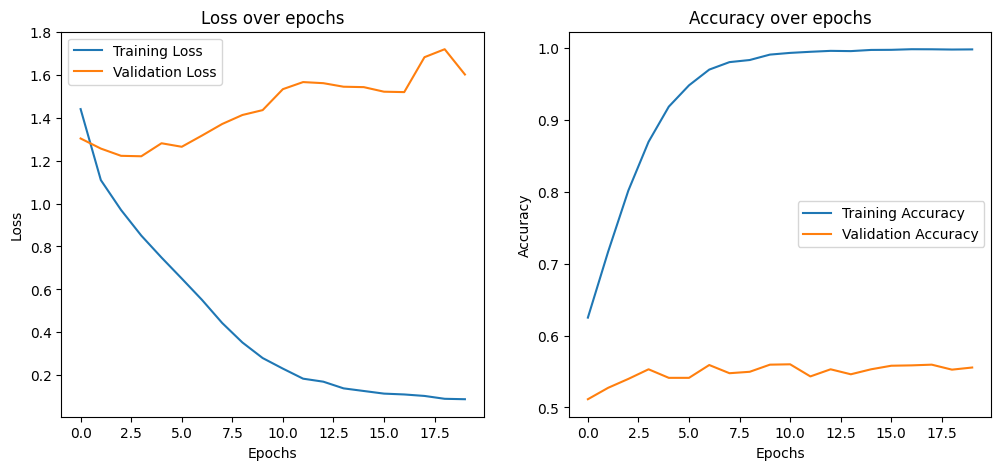

In [139]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [109]:

# Save the model
torch.save(model.state_dict(), Path(model_dir / 'emotion_resnet50.pth'))


In [118]:

# Inference on a single image
def predict_emotion(image_path, model, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust size to match your model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                           std=[0.229, 0.224, 0.225])
    ])
    emotion_classes = ['fear', 'neutral', 'surprise', 'anger', 'contempt', 'disgust', 'sad', 'happy']
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return emotion_classes[predicted.item()]

In [137]:

# Get list of subfolders in data_dir
subfolders = [f for f in os.listdir(data_dir) if (data_dir / f).is_dir()]

# Check if there are any subfolders
if not subfolders:
    raise FileNotFoundError("No subfolders found in the specified directory")

# Pick a random subfolder
random_subfolder = random.choice(subfolders)
subfolder_path = data_dir / random_subfolder

# Get list of image files in the random subfolder (supporting common image extensions)
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(image_extensions)]

# Check if there are any image files
if not image_files:
    raise FileNotFoundError("No image files found in the specified directory")

# Pick a random image file
random_image = random.choice(image_files)


# Replace the filename with the random image
test_image_path = Path(subfolder_path /  random_image)

Emotion Image:


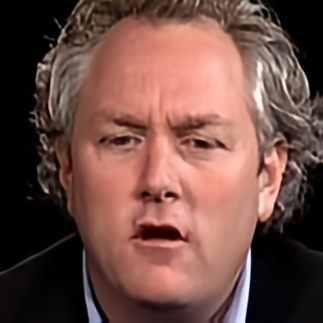

Predicted emotion: fear


In [138]:
# Test inference
image_path = test_image_path
emotion = predict_emotion(test_image_path, model, device)

print(f"Emotion Image:")
with open(test_image_path, 'rb') as file:
  image = Image.open(file)
  display(image)


print(f"Predicted emotion: {emotion}")

**ResNet Transfer learning with an intermediate layer**

In [140]:
# Load pre-trained ResNet-50
model = models.resnet50(weights='IMAGENET1K_V1')

# Modify the final fully connected layer to include an extra linear layer
num_features = model.fc.in_features  # 2048 for ResNet-50
hidden_units = 512  # Number of units in the intermediate layer (adjustable)

# Replace the fc layer with a sequential block
model.fc = nn.Sequential(
    nn.Linear(num_features, hidden_units),  # First linear layer: 2048 -> 512
    nn.ReLU(),                             # Activation function for non-linearity
    nn.Dropout(0.5),                       # Dropout to prevent overfitting (optional, adjustable)
    nn.Linear(hidden_units, 8)             # Output layer: 512 -> 8 (for 8 emotion classes)
)

# Move the model to the appropriate device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [141]:
# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [142]:
# Add earlystopping and checkpointing to train function

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device, patience=5, checkpoint_path='best_model.pth'):
    """
    Train a model with early stopping and checkpointing.
    
    Args:
        model: PyTorch model to train
        optimizer: Optimizer (e.g., Adam, SGD)
        loss_fn: Loss function (e.g., CrossEntropyLoss)
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        epochs: Number of epochs to train
        device: Device to train on (e.g., 'cuda' or 'cpu')
        patience: Number of epochs to wait for improvement before stopping (default: 5)
        checkpoint_path: Path to save the best model weights (default: 'best_model.pth')
    
    Returns:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        val_accuracies: List of validation accuracies per epoch
        best_epoch: Epoch at which the best validation loss was achieved
    """
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Early stopping variables
    best_val_loss = float('inf')  # Track the best validation loss
    epochs_no_improve = 0  # Counter for epochs without improvement
    best_epoch = 0  # Epoch with the best validation loss
    
    for epoch in range(1, epochs + 1):
        # Train
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validate
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch} Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Checkpointing: Save model if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            epochs_no_improve = 0
            # Save model state
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch} with Val Loss: {val_loss:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s)")
        
        # Early stopping: Stop if no improvement for 'patience' epochs
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch} epochs (no improvement for {patience} epochs)")
            break
    
    return train_losses, val_losses, val_accuracies, best_epoch

In [143]:
checkpoint_path=Path(model_dir / 'best_model.pth')

In [144]:
# Train the model

train_losses, val_losses, val_accuracies, best_epoch = train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=20,
    device=device,
    patience=5,
    checkpoint_path=checkpoint_path
)

print(f"Training stopped at epoch {best_epoch} with best validation loss.")


Epoch 1 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch 1: Train Loss: 1.7579, Val Loss: 1.5405, Val Acc: 0.4160
Checkpoint saved at epoch 1 with Val Loss: 1.5405


Epoch 2 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:29<00:00,  2.13it/s]


Epoch 2: Train Loss: 1.5193, Val Loss: 1.4584, Val Acc: 0.4530
Checkpoint saved at epoch 2 with Val Loss: 1.4584


Epoch 3 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:29<00:00,  2.14it/s]


Epoch 3: Train Loss: 1.3833, Val Loss: 1.4087, Val Acc: 0.4935
Checkpoint saved at epoch 3 with Val Loss: 1.4087


Epoch 4 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.40it/s]


Epoch 4: Train Loss: 1.2481, Val Loss: 1.1571, Val Acc: 0.5675
Checkpoint saved at epoch 4 with Val Loss: 1.1571


Epoch 5 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.39it/s]


Epoch 5: Train Loss: 1.1458, Val Loss: 1.2025, Val Acc: 0.5845
No improvement in validation loss for 1 epoch(s)


Epoch 6 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.43it/s]


Epoch 6: Train Loss: 1.0586, Val Loss: 1.0944, Val Acc: 0.6140
Checkpoint saved at epoch 6 with Val Loss: 1.0944


Epoch 7 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch 7: Train Loss: 0.9789, Val Loss: 1.0154, Val Acc: 0.6375
Checkpoint saved at epoch 7 with Val Loss: 1.0154


Epoch 8 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.42it/s]


Epoch 8: Train Loss: 0.8920, Val Loss: 1.0718, Val Acc: 0.6285
No improvement in validation loss for 1 epoch(s)


Epoch 9 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch 9: Train Loss: 0.8034, Val Loss: 0.9966, Val Acc: 0.6520
Checkpoint saved at epoch 9 with Val Loss: 0.9966


Epoch 10 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch 10: Train Loss: 0.7176, Val Loss: 1.0701, Val Acc: 0.6475
No improvement in validation loss for 1 epoch(s)


Epoch 11 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.40it/s]


Epoch 11: Train Loss: 0.6355, Val Loss: 1.1656, Val Acc: 0.6405
No improvement in validation loss for 2 epoch(s)


Epoch 12 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.40it/s]


Epoch 12: Train Loss: 0.5568, Val Loss: 1.2274, Val Acc: 0.6440
No improvement in validation loss for 3 epoch(s)


Epoch 13 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.38it/s]


Epoch 13: Train Loss: 0.4891, Val Loss: 1.2437, Val Acc: 0.6450
No improvement in validation loss for 4 epoch(s)


Epoch 14 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.39it/s]


Epoch 14: Train Loss: 0.3988, Val Loss: 1.2634, Val Acc: 0.6705
No improvement in validation loss for 5 epoch(s)
Early stopping triggered after 14 epochs (no improvement for 5 epochs)
Training stopped at epoch 9 with best validation loss.


In [151]:
def select_testimage_predict(data_dir, model_path, device):
    # Get list of subfolders in data_dir
    subfolders = [f for f in os.listdir(data_dir) if (data_dir / f).is_dir()]
    
    # Check if there are any subfolders
    if not subfolders:
        raise FileNotFoundError("No subfolders found in the specified directory")
    
    # Pick a random subfolder
    random_subfolder = random.choice(subfolders)
    subfolder_path = data_dir / random_subfolder
    
    # Get list of image files in the random subfolder (supporting common image extensions)
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
    image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(image_extensions)]
    
    # Check if there are any image files
    if not image_files:
        raise FileNotFoundError("No image files found in the specified directory")
    
    # Pick a random image file
    random_image = random.choice(image_files)
    
    # Replace the filename with the random image
    test_image_path = Path(subfolder_path / random_image)

    # Load the model
    model = models.resnet50(weights=None)
    num_features = model.fc.in_features
    hidden_units = 512
    model.fc = nn.Sequential(
        nn.Linear(num_features, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_units, 8)
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Test inference
    image_path = test_image_path
    emotion = predict_emotion(test_image_path, model, device)
    
    # Print the ground truth label (subfolder name)
    print(f"Ground truth label: {random_subfolder}")
    print(f"Emotion Image:")
    with open(test_image_path, 'rb') as file:
        image = Image.open(file)
        display(image)
    
    print(f"Predicted emotion: {emotion}")

Ground truth label: neutral
Emotion Image:


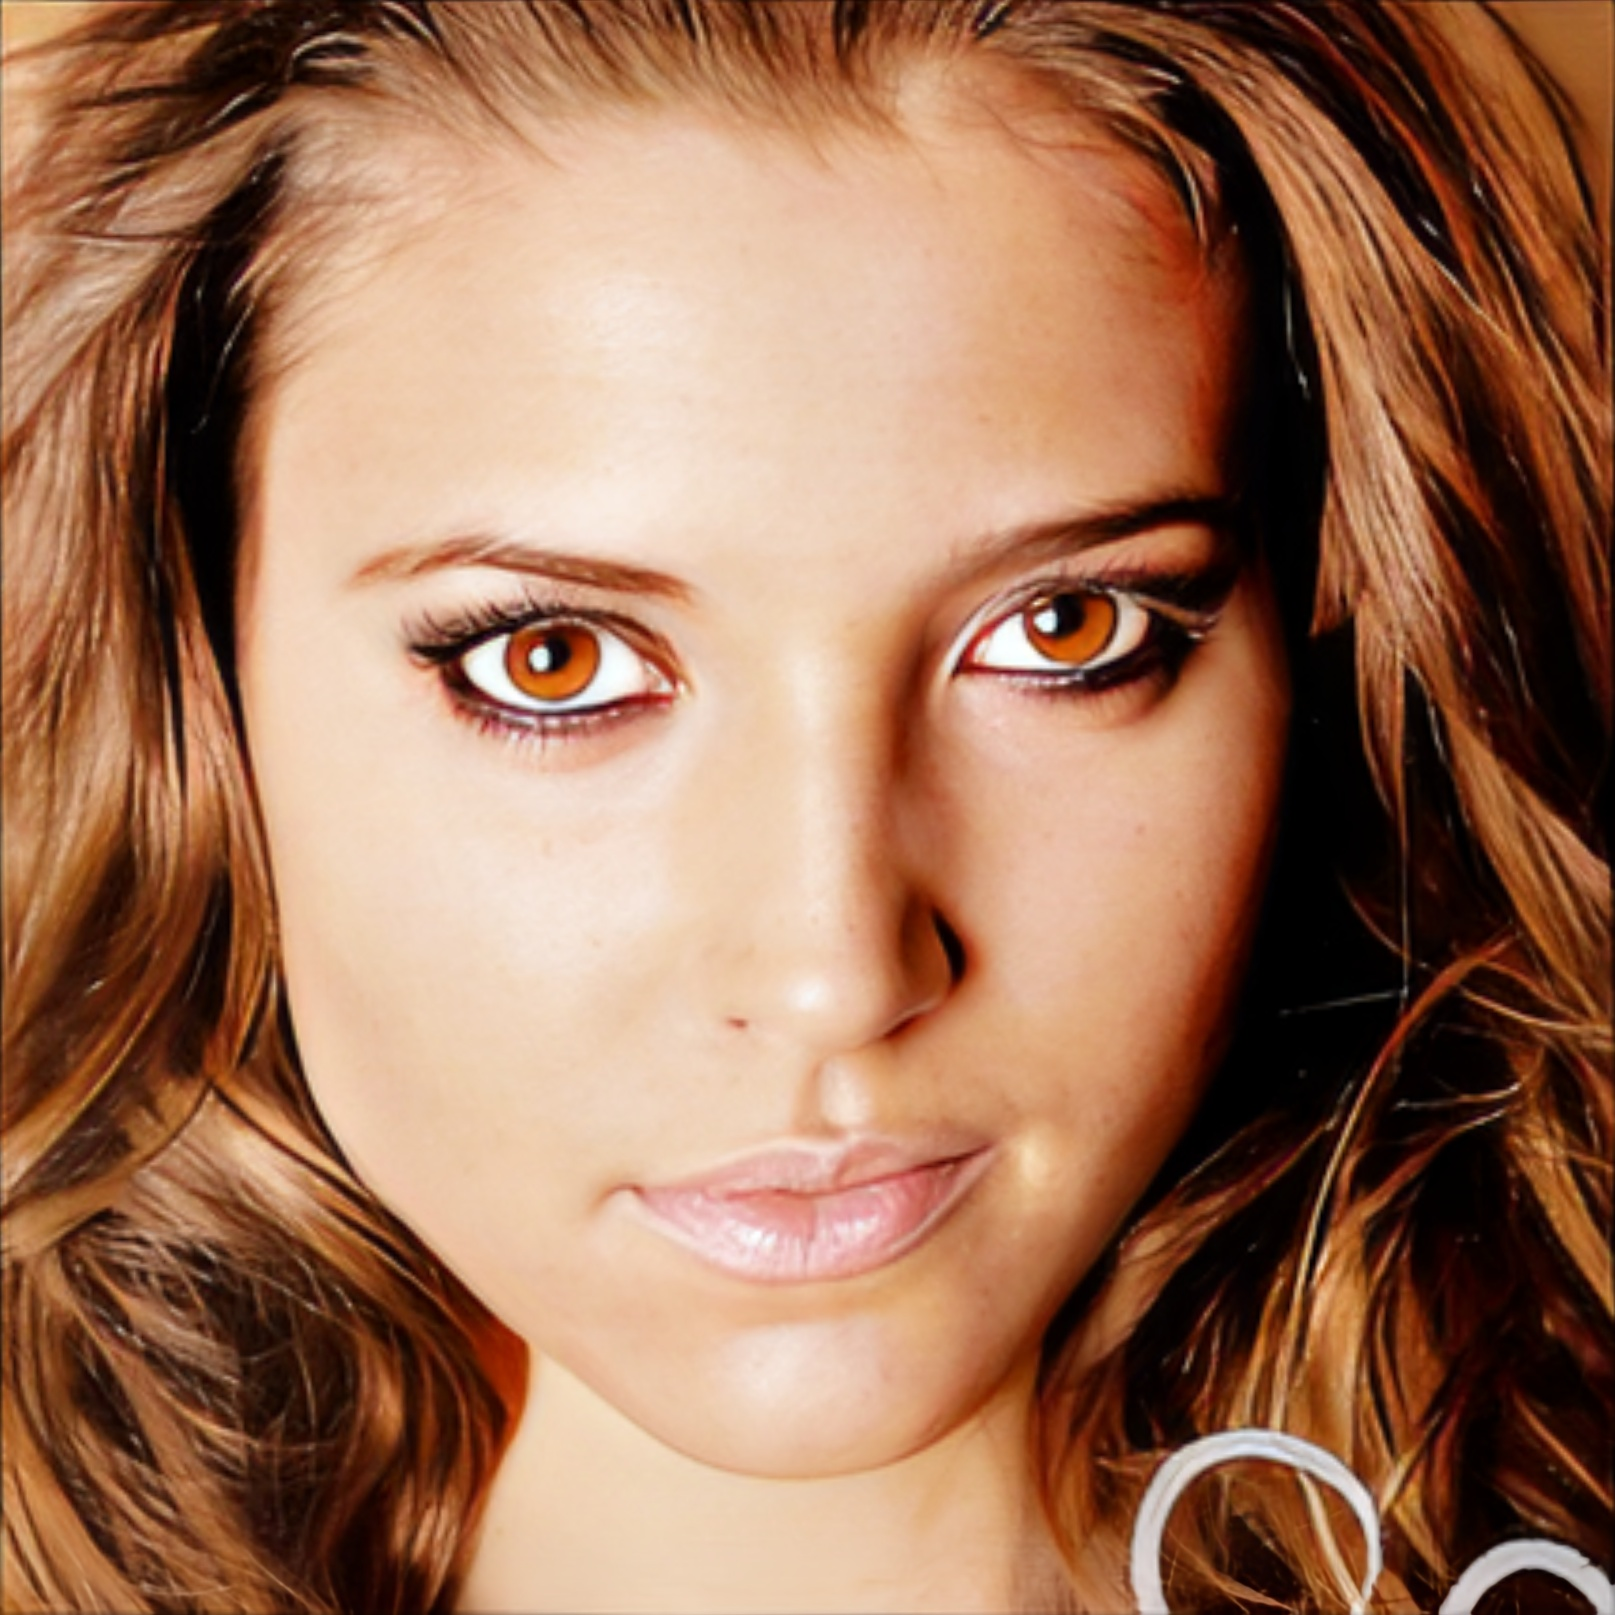

Predicted emotion: neutral


In [162]:
select_testimage_predict(data_dir, checkpoint_path, device)